In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import matplotlib as mpl

from os import listdir
from scipy.stats import f_oneway
from scipy.stats.mstats import gmean
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, correlation, cdist

rcParams = {'font.size': 24 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal', 'lines.linewidth':3}
plt.rcParams.update(rcParams)


In [9]:

def Plot_Heatmap(Dist_Mat, Feature_Mat, index_vec, sample_spring, method = 'average', 
                 plot_feature = True):
    plt.rcParams.update(rcParams)
    #cmap = mpl.cm.YlOrBr
    #bounds = np.arange(0.0, np.max(Dist_Mat)+0.1, 0.075)
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='neither')

    fig = plt.figure(figsize=(22,17))
    axdendro = fig.add_axes([0.1,0.25,0.2,0.7])
    Y = sch.linkage(squareform(Dist_Mat), method=method, optimal_ordering=True)
    index = sch.dendrogram(Y, color_threshold = 0,orientation='right')['leaves']
    ticks = np.array(index_vec)
    
    axmatrix = fig.add_axes([0.31,0.25,0.62,0.7])

    if (plot_feature):
        MAT = Feature_Mat
        MAT = MAT[index,:]
        MAT = np.round(MAT, 2)
    else:
        MAT = Dist_Mat
        MAT = MAT[index,:]
        MAT = MAT[:,index]
        MAT = np.round(MAT, 2)
    
    im = axmatrix.imshow(MAT, cmap  = "GnBu", aspect='auto', origin='lower', alpha = 1.0)
    x_ticklabels = []
    for t in ticks[index]:
        t = t.replace("Hotspr20Sample","").replace("Hotspr2Sample","").replace("HotsprSample","")\
             .replace("HotsprSampl","").replace("HotsprSamp","").replace("Hotspr","")
        x_ticklabels.append(t)
    
    axdendro.set_yticklabels(x_ticklabels, size = 16)
    
    a = [axdendro.get_yticklabels()[i].set_color('red')  
         if (sample_spring[ticks[index][i]] == 'Mushroom' ) 
         else axdendro.get_yticklabels()[i].set_color('blue') 
         for i in range(len(axdendro.get_yticklabels()))]
    
    if (not plot_feature):
        axmatrix.set_xticks(list(range(0, len(ticks))))
        axmatrix.set_xticklabels(x_ticklabels, rotation = 90, size = 20)
        axmatrix.xaxis.set_ticks_position('bottom')
        axmatrix.set_xticks(np.arange(-.5, 34, 1), minor=True)
        
        a = [axmatrix.get_xticklabels()[i].set_color('red')  
             if (sample_spring[ticks[index][i]] == 'Mushroom' ) 
             else axmatrix.get_xticklabels()[i].set_color('blue') 
             for i in range(len(axmatrix.get_xticklabels()))]
    
    
    ng = len(ticks)
    axmatrix.set_yticks(np.arange(-.5, 34, 1), minor=True)
    axmatrix.grid(which='minor', color='black', linestyle='-', linewidth=1)
    axmatrix.set_yticks([])
    axcolor = fig.add_axes([0.94,0.25,0.0075,0.7])
    fig.colorbar(im, cax=axcolor)
    axcolor.set_ylabel(r'Bray-Curtis Dissimilarity')

    fig.subplots_adjust(bottom = 0.001, left = 0.01)
    
    return fig

def Perform_PCA(FM, index, df_meta):
    pca = PCA(n_components=2)
    pca.fit(FM)
    transformed = pca.transform(FM)
    df_new = pd.DataFrame(transformed, columns = ['PC-1','PC-2'])
    df_new.index = index
    df_new = df_new.join(df_meta[['Spring_Name']])
    octopus = df_new[df_new['Spring_Name'] == 'Octopus'][['PC-1','PC-2']].values
    mushroom = df_new[df_new['Spring_Name'] == 'Mushroom'][['PC-1','PC-2']].values
    f, p = f_oneway(octopus, mushroom, axis = 0)
    print(pca.explained_variance_ratio_)
    print('f:',f, 'p:',p, '\n')
    return {'PC-transfomed':df_new, 'variance':pca.explained_variance_ratio_, 'f':f, 'p':p}

In [10]:
df_Metadata = pd.read_csv('/Users/harihara/Research-Activities/Data/Hot-Spring/hotspring_metadata.csv', 
                              sep = ",", index_col = 'SampleID')
sample_spring = dict(zip(df_Metadata.index.tolist(), df_Metadata.Spring_Name.tolist()))
data_dir = '/Users/harihara/Mount/Hotsprings_Variant_Structure_Data_Analysis/'
PCA_Dict = {} 

In [11]:
aero_coverage = data_dir+'AEROPHILUM/Filtered_Representative_Coverages/Summarized_Coverages/'
df_aero_eggnog = pd.read_excel(data_dir+'AEROPHILUM/Filtered.Eggnog.Annotations.xlsx')
representatives = df_aero_eggnog['RepresentativeContig'].unique().tolist()
Dist_Aerophilum, Feature_Aerophilum, index = Load_Coverage_Summary(aero_coverage, representatives)
PCA_Dict['Aerophilum'] = Perform_PCA(Feature_Aerophilum, index, df_Metadata)

[0.52435916 0.27656851]
f: [0.2100899  2.24862868] p: [0.6497947  0.14353501] 



In [13]:
chlor_msg_coverage = data_dir+'CHLOROFLEXUS_MS_G/Filtered_Representative_Coverages/Summarized_Coverages/'
df_chlor_msg_eggnog = pd.read_excel(data_dir+'CHLOROFLEXUS_MS_G/Filtered.Eggnog.Annotations.xlsx')
representatives = df_chlor_msg_eggnog['RepresentativeContig'].unique().tolist()
Dist_Chloroflexus, Feature_Chloroflexus, index = Load_Coverage_Summary(chlor_msg_coverage, representatives)
PCA_Dict['Chloroflexus MS G'] = Perform_PCA(Feature_Chloroflexus, index, df_Metadata)

[0.63657203 0.12777677]
f: [17.04682409  4.80853757] p: [0.00024357 0.03570415] 



In [14]:
syn_coverage = data_dir+'Synechococcus/Filtered_Representative_Coverages/Summarized_Coverages/'
df_syn_eggnog = pd.read_excel(data_dir+'Synechococcus/Filtered.Eggnog.Annotations.xlsx')
representatives = df_syn_eggnog['RepresentativeContig'].unique().tolist()
Dist_Synechococcus,  Feature_Synechococcus, index = Load_Coverage_Summary(syn_coverage, representatives)
PCA_Dict['Synechococcus'] = Perform_PCA(Feature_Synechococcus, index, df_Metadata)

[0.82610188 0.07278067]
f: [ 7.31161958 17.22892481] p: [0.01088019 0.00022886] 



In [16]:
chloracidobacterium_coverage = data_dir+'CHLORACIDOBACTERIUM_THERMOPHILUM_B/Filtered_Representative_Coverages/Summarized_Coverages/'
df_chloracidobacterium_eggnog = pd.read_excel(data_dir+'CHLORACIDOBACTERIUM_THERMOPHILUM_B/Filtered.Eggnog.Annotations.xlsx')
representatives = df_chloracidobacterium_eggnog['RepresentativeContig'].unique().tolist()
Dist_Chloracidobacterium, Feature_Chloracidobacterium, index = Load_Coverage_Summary(chloracidobacterium_coverage,
                                                                                     representatives)
PCA_Dict['Chloracidobacterium'] = Perform_PCA(Feature_Chloracidobacterium, index, df_Metadata)

[0.57949489 0.23803804]
f: [0.25521154 0.12470721] p: [0.61689102 0.72629996] 



In [17]:
rosei_coverage = data_dir+'ROSEIFLEXUS/Filtered_Representative_Coverages/Summarized_Coverages/'
df_rosei_eggnog = pd.read_excel(data_dir+'ROSEIFLEXUS/Filtered.Eggnog.Annotations.xlsx')
representatives = df_rosei_eggnog['RepresentativeContig'].unique().tolist()
Dist_Roseiflexus, Feature_Roseiflexus,  index = Load_Coverage_Summary(rosei_coverage, representatives)
PCA_Dict['Roseiflexus'] = Perform_PCA(Feature_Roseiflexus, index, df_Metadata)

[0.68538059 0.12988214]
f: [14.8916398   4.47075529] p: [0.00051964 0.04236312] 



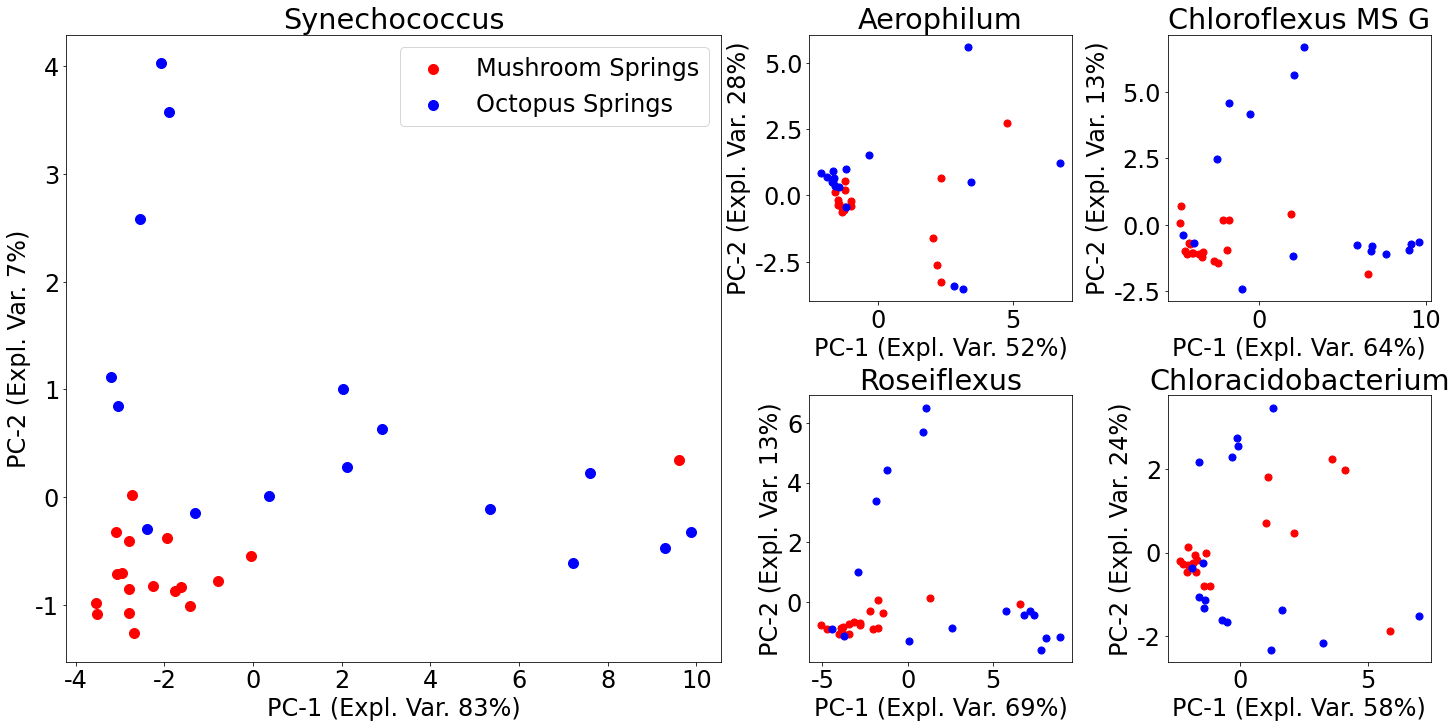

In [20]:
plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (20,10))
gs0 = fig.add_gridspec(1, 2)

gs1 = gs0[0].subgridspec(1,1)
ax0 = fig.add_subplot(gs1[0])

gs2 = gs0[1].subgridspec(2, 2)
ax1, ax2, ax3, ax4 = fig.add_subplot(gs2[0]), fig.add_subplot(gs2[1]), fig.add_subplot(gs2[2]), fig.add_subplot(gs2[3])

ax = [ax0, ax1, ax2, ax3, ax4]
keys = ['Synechococcus', 'Aerophilum', 'Chloroflexus MS G','Roseiflexus','Chloracidobacterium']
for i in range(len(keys)):
    df = PCA_Dict[keys[i]]['PC-transfomed']
    var = PCA_Dict[keys[i]]['variance']
    if i == 0: 
        df[df['Spring_Name'] == 'Mushroom'].plot.scatter('PC-1','PC-2', color = 'red', ax = ax[i], s = 100, 
                                                         label = 'Mushroom Springs')
        df[df['Spring_Name'] == 'Octopus'].plot.scatter('PC-1','PC-2', color = 'blue', ax = ax[i], s = 100, 
                                                        label = 'Octopus Springs')
    else: 
        df[df['Spring_Name'] == 'Mushroom'].plot.scatter('PC-1','PC-2', color = 'red', ax = ax[i], s = 50)
        df[df['Spring_Name'] == 'Octopus'].plot.scatter('PC-1','PC-2', color = 'blue', ax = ax[i], s = 50)
   
    
    ax[i].set_xlabel('PC-1 (Expl. Var. '+str(round(var[0]*100))+'%)')
    ax[i].set_ylabel('PC-2 (Expl. Var. '+str(round(var[1]*100))+'%)')
    ax[i].set_title(keys[i])
    

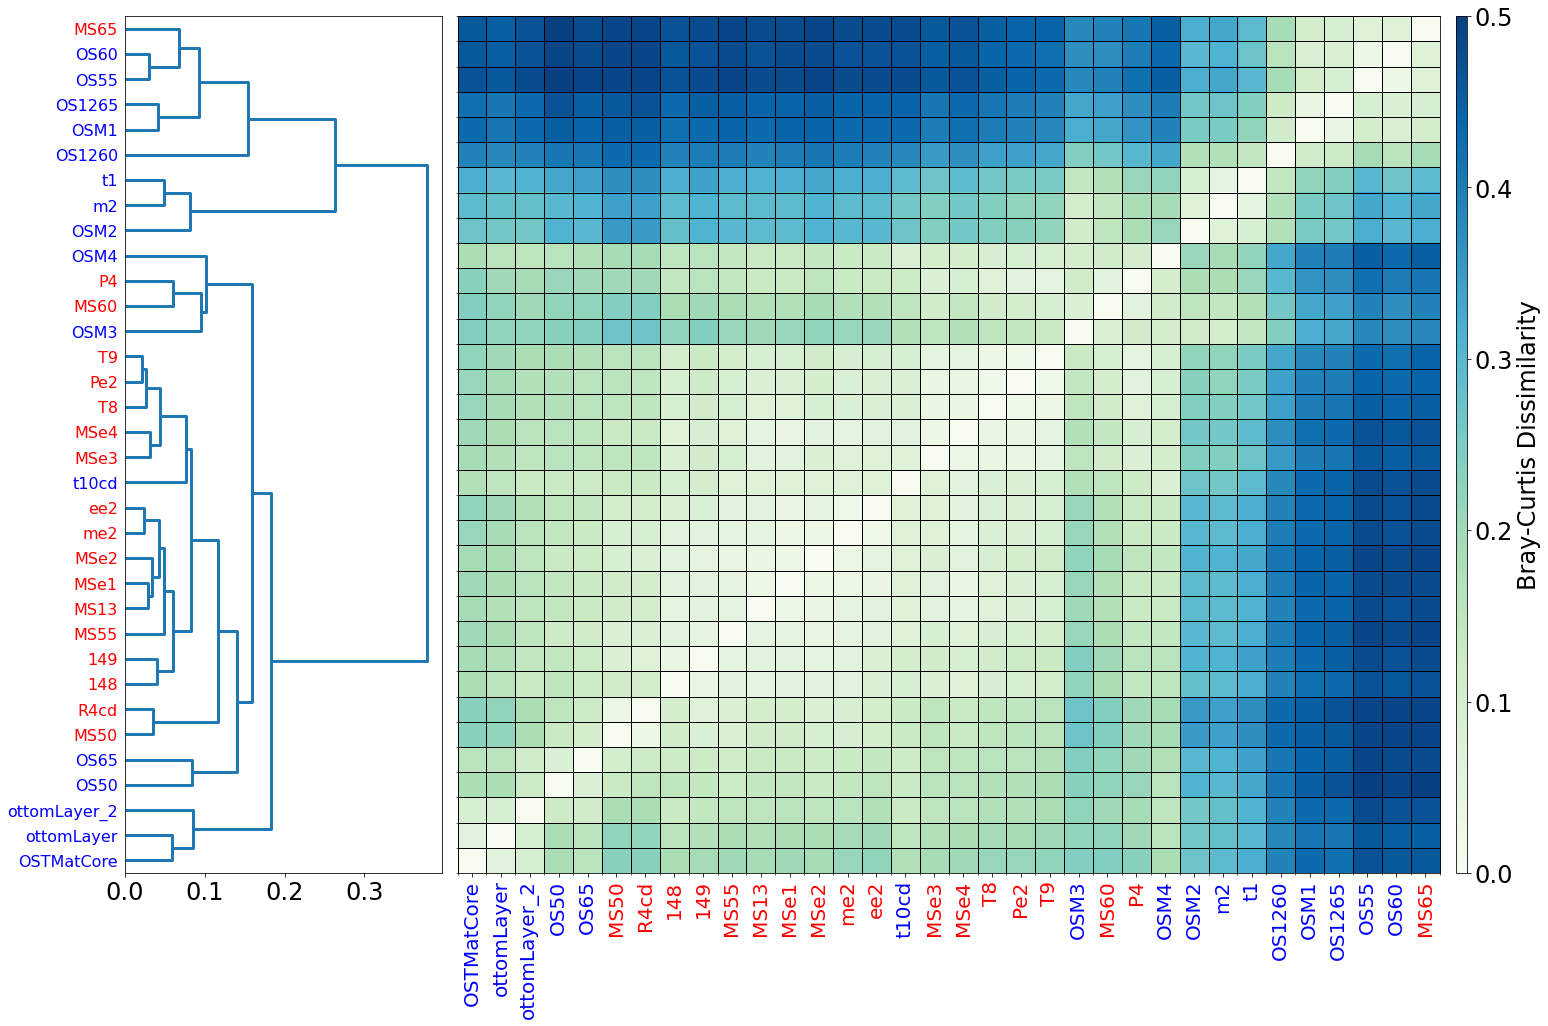

In [25]:
fig = Plot_Heatmap(Dist_Synechococcus, Feature_Synechococcus, index, sample_spring, 'average', 0)